In [ ]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [ ]:
df  = pd.read_csv("drive/MyDrive/data/XHB_HistoricalData_20241121.csv")
df.rename(columns={'Close/Last': 'Close'}, inplace=True)

# Prepare the data
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Sort the DataFrame by date in ascending order
df = df.sort_index()

# The day after tomorrow - High
X = df[['Open', 'High', 'Low', 'High', 'Volume']]
y = df['Close'].shift(-2).dropna()
X = X.iloc[:-2]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=99)
X_train = X_train.values
X_test = X_test.values

In [ ]:
df.head()

,Close,Volume,Open,High,Low
Date,,,,,
2019-11-21,45.09,1650216,45.42,45.570,45.080
2019-11-22,45.24,1521756,45.14,45.315,45.055
2019-11-25,45.73,2150075,45.35,45.800,45.350
2019-11-26,46.42,3639919,45.82,46.430,45.820
2019-11-27,46.30,2198190,46.50,46.675,46.250


In [ ]:
df.tail()

,Close,Volume,Open,High,Low
Date,,,,,
2024-11-15,115.68,1488207,116.20,116.610,115.33
2024-11-18,115.46,1114084,115.40,116.390,114.88
2024-11-19,115.40,986021,114.62,115.710,113.69
2024-11-20,116.55,1150510,116.30,116.728,115.51
2024-11-21,117.91,1023734,117.18,118.849,116.81


In [ ]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
### Random Forest ###

# Hyperparameter tuning using Grid Search for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
    }
grid_search = GridSearchCV(
    RandomForestRegressor(),
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error'
    )

# # Initialize GridSearchCV with tqdm
# class TQDMGridSearchCV(GridSearchCV):
#     def fit(self, X, y=None, **fit_params):
#         with tqdm(total=len(self.cv_results_['params'])) as pbar:
#             for i in range(len(self.cv_results_['params'])):
#                 super().fit(X, y, **fit_params)
#                 pbar.update(1)
#                 return self
# # Perform Grid Search with progress bar
# grid_search = TQDMGridSearchCV(
#     RandomForestRegressor(),
#     param_grid, cv=5,
#     scoring='neg_mean_squared_error'
#     )

grid_search.fit(X_train_scaled, y_train)

# Best model
best_rf = grid_search.best_estimator_

# Predict and evaluate
y_pred = best_rf.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Predict the next day's price
next_day_features = scaler.transform(
    df.iloc[-1][['Open', 'High', 'Low', 'Close', 'Volume']].values.reshape(1, -1)
    )
next_day_prediction = best_rf.predict(next_day_features)

# Tend to be higher than actual
print(f'Predicted next day price: {next_day_prediction[0]}')


Mean Squared Error: 3.9530563255850026
Predicted next day price: 115.74292486082544


In [ ]:
df

,Close,Volume,Open,High,Low
Date,,,,,
2019-11-21,45.09,1650216,45.42,45.570,45.080
2019-11-22,45.24,1521756,45.14,45.315,45.055
2019-11-25,45.73,2150075,45.35,45.800,45.350
2019-11-26,46.42,3639919,45.82,46.430,45.820
2019-11-27,46.30,2198190,46.50,46.675,46.250
...,...,...,...,...,...
2024-11-15,115.68,1488207,116.20,116.610,115.330
2024-11-18,115.46,1114084,115.40,116.390,114.880
2024-11-19,115.40,986021,114.62,115.710,113.690


Mean Squared Error: 4.1243203028174635
Predicted next day price: 115.61909999999985


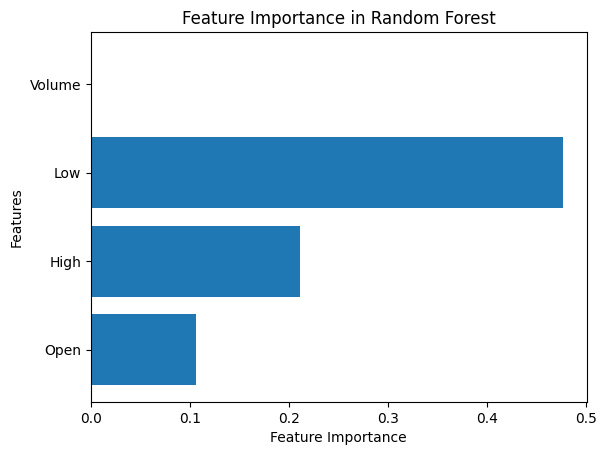

In [ ]:
# Train the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Feature importance
importance = rf.feature_importances_
features = X.columns
plt.barh(features, importance)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forest')

# Predict the next day's price
next_day_features = scaler.transform(
    df.iloc[-1][['Open', 'High', 'Low', 'Close', 'Volume']].values.reshape(1, -1)
    )
next_day_prediction = rf.predict(next_day_features)
print(f'Predicted next day price: {next_day_prediction[0]}')

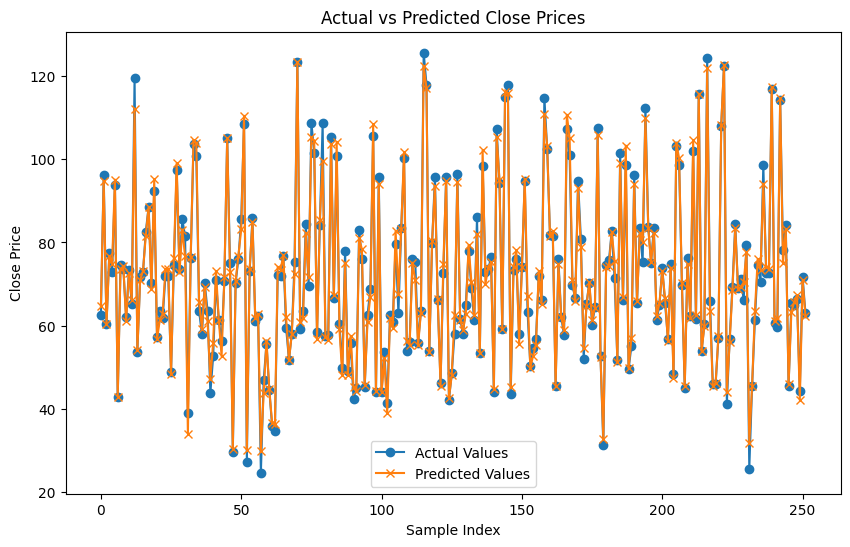

In [ ]:
# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Values', marker='o')
plt.plot(y_pred, label='Predicted Values', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Prices')
plt.legend()
plt.show()

In [ ]:
# # # Create a DataFrame for the test set with predictions
# # test_dates = X_test.index
# # predictions_df = pd.DataFrame(
# #     {'Date': test_dates,
# #      'Actual': y_test,
# #      'Predicted': y_pred}
# #     )
# # predictions_df.set_index('Date', inplace=True)

# # Convert y_test to a pandas Series with the same index as X_test
# y_test_series = pd.Series(y_test, index=X_test.index)
# # Create a DataFrame for the test set with predictions
# predictions_df = pd.DataFrame(
#     {'Actual': y_test_series, 'Predicted': y_pred})

# # Plot predictions vs actual values
# plt.figure(figsize=(10, 6))
# plt.plot(
#     predictions_df.index,
#     predictions_df['Actual'],
#     label='Actual Values',
#     marker='o'
#     )
# plt.plot(
#     predictions_df.index,
#     predictions_df['Predicted'],
#     label='Predicted Values',
#     marker='x'
#     )
# plt.xlabel('Date')
# plt.ylabel('Close Price')
# plt.title('Actual vs Predicted Close Prices')